### this script is trying to apply VAE to session-wise functional connectivity patterns

* functional connectivity patterns are derived from AAL atlas with 170 ROIs
* FC is calculated among 170 AAL ROIs (170*170 matrix) with NAN values


In [69]:
import numpy as np
from scipy.io import loadmat
import nibabel as nib
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
from sklearn import datasets, svm
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold

In [20]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [21]:
# Load subject info
SubInfo = pd.read_excel('/Users/liuq13/NODEAP_scripts/ProcessedData/SubConds.xlsx')
Subs = SubInfo[SubInfo['Include'] == 1]['SubID']
base_nifti_folder = '/Volumes/X9Pro/NODEAP/FuncConn_AAL'
sessions = ['D0', 'S1D1', 'S1D2', 'S2D1', 'S2D2', 'S3D1', 'S3D2']

In [22]:
SubInfo.head()

,SubID,Gender,Birth.Year,StimLoc,StimOrder,Odors,StartOdor,Age,Sex,Include,btS1,btS2,btS3,btS1S2,btS2S3
0,NODEAP_06,Male,1992,Posterior,321,"Chocolate, Garlic",Sweet,30.83,M,1,1,1,1,13,15
1,NODEAP_07,Female,1991,Anterior,312,"Pineapple, Pizza",Savory,32.01,F,1,1,1,1,20,13
2,NODEAP_08,Male,1996,Posterior,132,"Chocolate, Garlic",Sweet,26.19,M,1,1,1,1,12,14
3,NODEAP_09,Female,2000,Posterior,321,"Gingerbread, Garlic",Savory,22.32,F,1,1,1,1,14,27
4,NODEAP_10,Male,1999,Posterior,321,"Chocolate, Garlic",Savory,23.62,M,1,1,1,1,13,12


In [23]:
SubInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SubID       48 non-null     object 
 1   Gender      48 non-null     object 
 2   Birth.Year  48 non-null     int64  
 3   StimLoc     48 non-null     object 
 4   StimOrder   48 non-null     int64  
 5   Odors       48 non-null     object 
 6   StartOdor   48 non-null     object 
 7   Age         48 non-null     float64
 8   Sex         48 non-null     object 
 9   Include     48 non-null     int64  
 10  btS1        48 non-null     int64  
 11  btS2        48 non-null     int64  
 12  btS3        48 non-null     int64  
 13  btS1S2      48 non-null     int64  
 14  btS2S3      48 non-null     int64  
dtypes: float64(1), int64(8), object(6)
memory usage: 5.8+ KB


In [24]:
TMS_types = []

# Loop through each row and assign TMS types based on 'StimOrder'
for i, row in SubInfo.iterrows():
    tmp_order = row['StimOrder']
    
    # Assign TMS types based on the 'StimOrder' value
    if tmp_order == 123:
        TMS_types.append(['N', 'C', 'S', 'S', 'C', 'S', 'S'])
    elif tmp_order == 132:
        TMS_types.append(['N', 'C', 'S', 'S', 'S', 'S', 'C'])
    elif tmp_order == 213:
        TMS_types.append(['N', 'S', 'C', 'C', 'S', 'S', 'S'])
    elif tmp_order == 231:
        TMS_types.append(['N', 'S', 'C', 'S', 'S', 'C', 'S'])
    elif tmp_order == 312:
        TMS_types.append(['N', 'S', 'S', 'C', 'S', 'S', 'C'])
    elif tmp_order == 321:
        TMS_types.append(['N', 'S', 'S', 'S', 'C', 'C', 'S'])

print(TMS_types)

[['N', 'S', 'S', 'S', 'C', 'C', 'S'], ['N', 'S', 'S', 'C', 'S', 'S', 'C'], ['N', 'C', 'S', 'S', 'S', 'S', 'C'], ['N', 'S', 'S', 'S', 'C', 'C', 'S'], ['N', 'S', 'S', 'S', 'C', 'C', 'S'], ['N', 'C', 'S', 'S', 'C', 'S', 'S'], ['N', 'S', 'C', 'S', 'S', 'C', 'S'], ['N', 'S', 'C', 'S', 'S', 'C', 'S'], ['N', 'S', 'C', 'S', 'S', 'C', 'S'], ['N', 'S', 'C', 'C', 'S', 'S', 'S'], ['N', 'S', 'S', 'S', 'C', 'C', 'S'], ['N', 'S', 'C', 'C', 'S', 'S', 'S'], ['N', 'S', 'C', 'C', 'S', 'S', 'S'], ['N', 'C', 'S', 'S', 'S', 'S', 'C'], ['N', 'C', 'S', 'S', 'C', 'S', 'S'], ['N', 'C', 'S', 'S', 'C', 'S', 'S'], ['N', 'S', 'S', 'S', 'C', 'C', 'S'], ['N', 'S', 'C', 'C', 'S', 'S', 'S'], ['N', 'C', 'S', 'S', 'C', 'S', 'S'], ['N', 'C', 'S', 'S', 'C', 'S', 'S'], ['N', 'S', 'S', 'C', 'S', 'S', 'C'], ['N', 'S', 'C', 'C', 'S', 'S', 'S'], ['N', 'C', 'S', 'S', 'C', 'S', 'S'], ['N', 'S', 'S', 'S', 'C', 'C', 'S'], ['N', 'S', 'C', 'S', 'S', 'C', 'S'], ['N', 'S', 'S', 'C', 'S', 'S', 'C'], ['N', 'S', 'S', 'S', 'C', 'C', 'S'], 

In [25]:
# define a function to get upper triangle values of FC matrix
def vectorize_fc(fc_mat):
    # Upper triangle, excluding diagonal
    return fc_mat[np.triu_indices(fc_mat.shape[0], k=1)]

In [34]:
all_corr_data = []
all_tms_type = []
all_subject_id = []

for i, subject_id in enumerate(Subs):
    tms_types = TMS_types[i]  
    for j, session in enumerate(sessions):
        mat_file = os.path.join(base_nifti_folder, subject_id, session, 'conn_matrix.mat')
        if os.path.exists(mat_file):
            matdat = loadmat(mat_file)
            dat_corr = matdat['FC_matrix'] 
            dat_vec = vectorize_fc(dat_corr)  # <- vectorized
            all_corr_data.append(dat_vec)
            all_tms_type.append(tms_types[j])  # keep condition label
            all_subject_id.append(subject_id)
        else:
            print(f"matfile not found: {mat_file}")

matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_30/S3D2/conn_matrix.mat
matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_83/S3D1/conn_matrix.mat
matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_87/D0/conn_matrix.mat
matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_88/D0/conn_matrix.mat


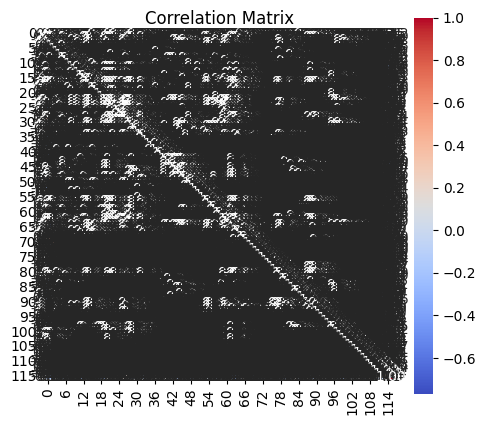

In [40]:
plt.figure(figsize=(5, 5))
sns.heatmap(dat_corr, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [43]:
# Map 'N' = 0 (Null), 'S' = 1 (Sham), 'C' = 2 (Real/cTBS)
label_map = {'N': 0, 'S': 1, 'C': 2}
y = np.array([label_map[t] for t in all_tms_type])

In [45]:
X = np.array(all_corr_data)  # shape: (num_sessions, 14365)
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)  # Standardize per feature
X.shape

(332, 6670)

In [47]:
print("Any NaN in X?", np.isnan(X).any())

Any NaN in X? True


In [48]:
nan_cols = np.isnan(X).any(axis=0)
print(f"Columns with NaN: {nan_cols.sum()} / {X.shape[1]}")
X_clean = X[:, ~nan_cols]

print("X_clean shape:", X_clean.shape)
print("Any NaNs in X_clean?", np.isnan(X_clean).any())


Columns with NaN: 229 / 6670
X_clean shape: (332, 6441)
Any NaNs in X_clean? False


In [49]:
X = X_clean

In [52]:
input_dim = X.shape[1]  
latent_dim = 10
input_dim

6441

In [53]:
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(X_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [54]:
# define VAE functions

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2_mu = nn.Linear(256, latent_dim)
        self.fc2_logvar = nn.Linear(256, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        logvar = torch.clamp(logvar, min=-10, max=10)  # Prevent NaNs
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return self.fc4(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # also mean here
    return recon_loss + kld


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [56]:
# Training loop
for epoch in range(50):
    total_loss = 0
    for (batch,) in dataloader:
        batch = batch.to(device)
        recon, mu, logvar = model(batch)
        loss = vae_loss(recon, batch, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Loss {total_loss:.2f}")

Epoch 0: Loss 11.97
Epoch 1: Loss 11.76
Epoch 2: Loss 11.72
Epoch 3: Loss 11.48
Epoch 4: Loss 11.50
Epoch 5: Loss 11.45
Epoch 6: Loss 11.47
Epoch 7: Loss 11.57
Epoch 8: Loss 11.33
Epoch 9: Loss 11.39
Epoch 10: Loss 11.31
Epoch 11: Loss 11.27
Epoch 12: Loss 11.23
Epoch 13: Loss 11.23
Epoch 14: Loss 11.27
Epoch 15: Loss 11.24
Epoch 16: Loss 11.25
Epoch 17: Loss 11.20
Epoch 18: Loss 11.20
Epoch 19: Loss 11.27
Epoch 20: Loss 11.34
Epoch 21: Loss 11.14
Epoch 22: Loss 11.21
Epoch 23: Loss 11.20
Epoch 24: Loss 11.17
Epoch 25: Loss 11.20
Epoch 26: Loss 11.16
Epoch 27: Loss 11.15
Epoch 28: Loss 11.18
Epoch 29: Loss 11.19
Epoch 30: Loss 11.19
Epoch 31: Loss 11.14
Epoch 32: Loss 11.20
Epoch 33: Loss 11.17
Epoch 34: Loss 11.18
Epoch 35: Loss 11.17
Epoch 36: Loss 11.11
Epoch 37: Loss 11.14
Epoch 38: Loss 11.12
Epoch 39: Loss 11.13
Epoch 40: Loss 11.09
Epoch 41: Loss 11.10
Epoch 42: Loss 11.12
Epoch 43: Loss 11.14
Epoch 44: Loss 11.12
Epoch 45: Loss 11.08
Epoch 46: Loss 11.12
Epoch 47: Loss 11.17
Ep

In [58]:
model.eval()
with torch.no_grad():
    mu_all = []
    for i in range(X.shape[0]):
        x = torch.tensor(X[i], dtype=torch.float32).to(device).unsqueeze(0)
        mu, _ = model.encode(x)
        mu_all.append(mu.cpu().numpy().flatten())
mu_all = np.array(mu_all)


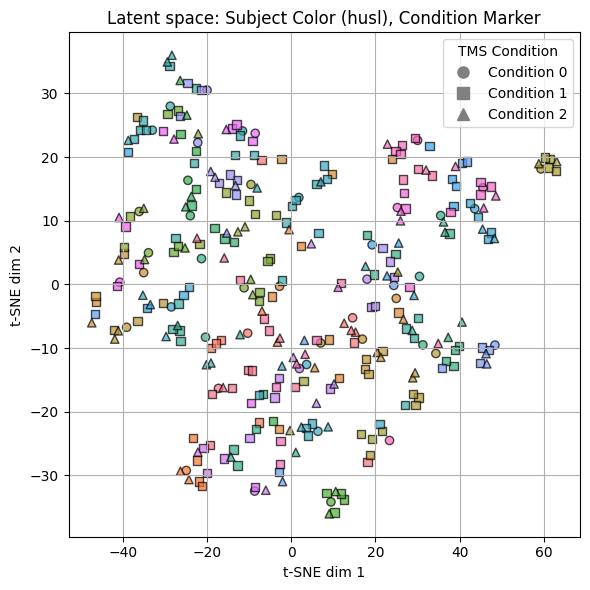

In [90]:
# Step 1: TSNE
z_2d = TSNE(n_components=2, perplexity=10).fit_transform(mu_all)

# Step 2: Prepare subject and condition data
subject_array = np.array(all_subject_id)
y = np.array(y).flatten()

unique_subjects = np.unique(subject_array)
subject_to_idx = {subj: i for i, subj in enumerate(unique_subjects)}
subject_idx = np.array([subject_to_idx[subj] for subj in subject_array])

# Step 3: Assign distinct colors using Seaborn
palette = sns.color_palette("husl", len(unique_subjects))  # 48 distinct hues
subject_colors = np.array([palette[i] for i in subject_idx])

# Step 4: Marker style per condition
unique_conds = np.unique(y)
markers = ['o', 's', '^', 'v', 'D']
cond_to_marker = {cond: markers[i] for i, cond in enumerate(unique_conds)}

# Step 5: Plot each condition group with its marker and subject-based color
fig, ax = plt.subplots(figsize=(6, 6))

for cond in unique_conds:
    mask = y == cond
    ax.scatter(
        z_2d[mask, 0],
        z_2d[mask, 1],
        marker=cond_to_marker[cond],
        c=subject_colors[mask],
        label=f'Condition {cond}',
        edgecolors='k',
        alpha=0.7
    )

# Add legend for condition markers only
handles = [plt.Line2D([0], [0], marker=cond_to_marker[c], color='gray', linestyle='',
                      label=f'Condition {c}', markersize=8) for c in unique_conds]
ax.legend(handles=handles, title='TMS Condition', loc='upper right')

ax.set_title("Latent space: Subject Color (husl), Condition Marker")
ax.set_xlabel("t-SNE dim 1")
ax.set_ylabel("t-SNE dim 2")
ax.grid(True)
plt.tight_layout()
plt.show()


In [63]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=0)
z_umap = reducer.fit_transform(mu_all)

/Users/liuq13/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuq13/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


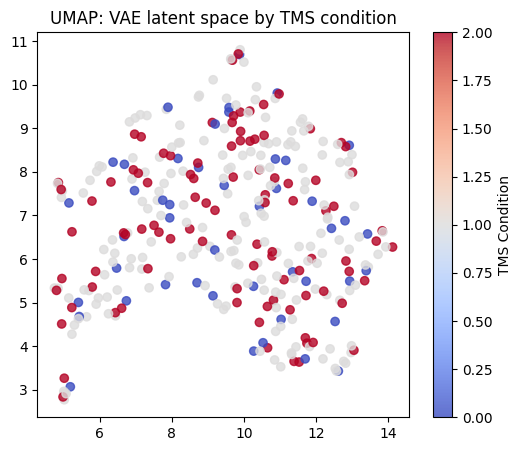

In [64]:
plt.figure(figsize=(6,5))
plt.scatter(z_umap[:, 0], z_umap[:, 1], c=y, cmap='coolwarm', alpha=0.8)
plt.title("UMAP: VAE latent space by TMS condition")
plt.colorbar(label='TMS Condition')
plt.show()

In [65]:
clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, mu_all, y, cv=5)
print("Multiclass accuracy (Null vs Sham vs Real):", scores.mean())


Multiclass accuracy (Null vs Sham vs Real): 0.5723202170963365


In [66]:
mask_C = (y == 2)
mask_S = (y == 1)

X_bin = np.vstack([mu_all[mask_C], mu_all[mask_S]])
y_bin = np.array([1] * mask_C.sum() + [0] * mask_S.sum())

clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, X_bin, y_bin, cv=5)
print("Binary accuracy (Real vs Sham):", scores.mean())


Binary accuracy (Real vs Sham): 0.6643678160919539


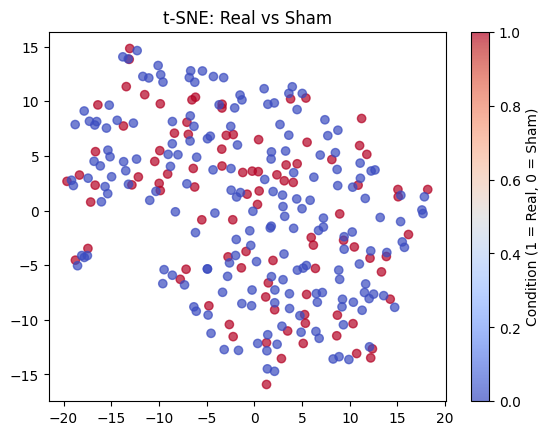

In [67]:
# if only plot real and sham

X_bin = np.vstack([mu_all[y == 2], mu_all[y == 1]])
y_bin = np.array([1] * sum(y == 2) + [0] * sum(y == 1))

z_2d = TSNE(n_components=2).fit_transform(X_bin)

plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_bin, cmap='coolwarm', alpha=0.7)
plt.title("t-SNE: Real vs Sham")
plt.colorbar(label="Condition (1 = Real, 0 = Sham)")
plt.show()
